In [1]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [2]:
import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import msgpack
import warnings
from dataclasses import asdict, is_dataclass, dataclass
import os
import msgpack
import json
import pickle
from pandas.api.types import is_datetime64_any_dtype
import scipy
import numpy as np
import polars as pl
from scipy.stats import linregress
from typing import Dict, List
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from src.common.AssetData import AssetData
from src.common.AssetDataPolars import AssetDataPolars
from src.common.AssetDataService import AssetDataService
from src.common.AssetFileInOut import AssetFileInOut 
from src.databaseService.OutsourceLoader import OutsourceLoader

from src.simulation.SimulatePortfolio import SimulatePortfolio
from src.strategy.StratBuyAndHold import StratBuyAndHold
from src.simulation.ResultAnalyzer import ResultAnalyzer
from src.common.AssetFileInOut import AssetFileInOut
from src.mathTools.CurveAnalysis import CurveAnalysis
from src.mathTools.SeriesExpansion import SeriesExpansion
from src.predictionModule.FourierML import FourierML
from src.common.YamlTickerInOut import YamlTickerInOut
from src.common.DataFrameTimeOperations import DataFrameTimeOperationsPandas as DFTO


In [3]:
assets=AssetFileInOut("../src/stockGroups/bin").loadDictFromFile("group_snp500_over20years")

# Convert to Polars for speedup
assetspl: Dict[str, AssetDataPolars] = {}
for ticker, asset in assets.items():
    assetspl[ticker]= AssetDataService.to_polars(asset)

In [4]:
ticker ="MMM"
aIRM = assetspl[ticker]
pricesArray = aIRM.adjClosePrice["AdjClose"]
currDatediff = 500*5
aidx = len(pricesArray) - currDatediff
pastPrices = pricesArray.slice(aidx-24 * 21, 24 * 21 +1).to_numpy()

aIRM.adjClosePrice["Date"].item(aidx)

datetime.datetime(2014, 11, 19, 0, 0)

In [5]:
startDate=pd.Timestamp(year=2019, month=9, day=4)
endDate=pd.Timestamp(year=2020, month=1, day=4)
fourierTestML = FourierML(assetspl, startDate, endDate)

fourierTestML.prepareData()

Processing asset: MMM.  Processed 0 out of 390.
Processing asset: AOS.  Processed 1 out of 390.
Processing asset: ABT.  Processed 2 out of 390.
Processing asset: ACN.  Processed 3 out of 390.
Processing asset: AES.  Processed 4 out of 390.
Processing asset: AFL.  Processed 5 out of 390.
Processing asset: A.  Processed 6 out of 390.
Processing asset: APD.  Processed 7 out of 390.
Processing asset: ALB.  Processed 8 out of 390.
Processing asset: ARE.  Processed 9 out of 390.
Processing asset: LNT.  Processed 10 out of 390.
Processing asset: ALL.  Processed 11 out of 390.
Processing asset: MO.  Processed 12 out of 390.
Processing asset: AEE.  Processed 13 out of 390.
Processing asset: AEP.  Processed 14 out of 390.
Processing asset: AXP.  Processed 15 out of 390.
Processing asset: AIG.  Processed 16 out of 390.
Processing asset: AMT.  Processed 17 out of 390.
Processing asset: AME.  Processed 18 out of 390.
Processing asset: APH.  Processed 19 out of 390.
Processing asset: AON.  Processed

C:\Users\KILightTouch\AppData\Local\Temp\ipykernel_22664\1844540972.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=fourierTestML.y, palette='viridis')


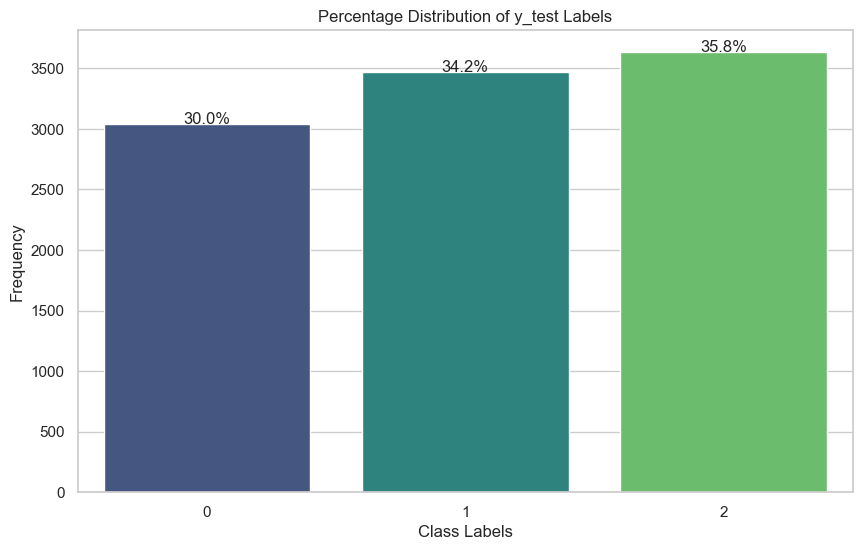

0.33517887640099747


In [7]:
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
total = len(fourierTestML.y)
sns.countplot(x=fourierTestML.y, palette='viridis')

# Add percentage labels on top of each bar
percentage= []
for p in plt.gca().patches:
    perc = '{:.1f}%'.format(100 * p.get_height() / total)
    percentage.append(p.get_height() / total)
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2., height + 1, perc, ha="center") 

plt.title('Percentage Distribution of y_test Labels')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.show()

percentage= np.array(percentage)
print(np.sum(percentage ** 2))

In [10]:
from sklearn.model_selection import train_test_split
from src.mathTools.RandomProjectionClassifier import RandomProjectionClassifier as rpc
X_train, X_test, y_train, y_test = train_test_split(fourierTestML.X, fourierTestML.y, test_size=.2)

# Initialize the classifier
fourierRPCModel = rpc(
    num_random_features=5000,
    regularization=30,
    max_iter=10,
    verbose=True,
    random_state=None
)
# Train the model
fourierRPCModel.fit(X_train, y_train)

fourierRPCModel.tune_regularization(X_train, y_train, low_start=1, high_start=10, max_iter=3)
print(fourierRPCModel.g)
fourierRPCModel.compute_accuracy(g=fourierRPCModel.g, Y_test = y_test, X_test=X_test)

Iteration 1: acc = 0.4427, g = 1.0000, low = 1.0000, high = 5.5000
Iteration 2: acc = 0.4427, g = 1.0000, low = 1.0000, high = 3.2500
Iteration 3: acc = 0.4427, g = 1.0000, low = 1.0000, high = 2.1250
Best accuracy: 0.4427 with g = 1.0000
1


0.398422090729783

In [33]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fourierTestML.X, fourierTestML.y, test_size=.2)

num_classes = len(np.unique(fourierTestML.y))
y_cat_train = to_categorical(y_train, num_classes)
y_cat_test = to_categorical(y_test, num_classes)

# Define the model
fourierLGBMModel = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate = 0.01,
    max_depth=5,
    num_leaves=2 ** 5,
    colsample_bytree=0.1
)

# Train the model
fourierLGBMModel.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 8112, number of used features: 100
[LightGBM] [Info] Start training from score 1.047707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000, num_leaves=32)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fourierTestML.X, fourierTestML.y, test_size=.2)
input_shape = X_train.shape[1]
output_shape = 2*1+1
num_classes = len(np.unique(fourierTestML.y))
y_cat_train = to_categorical(y_train, num_classes)
y_cat_test = to_categorical(y_test, num_classes)

fourierTestCNNModel = models.Sequential()
# Define the model
fourierTestCNNModel = models.Sequential([
            layers.Dense(16, activation='relu', input_shape=(input_shape,)),
            layers.Dropout(0.2),
            layers.Dense(8, activation='relu'),
            layers.Dense(output_shape, activation='softmax')
])

fourierTestCNNModel.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

history = fourierTestCNNModel.fit(X_train, y_cat_train,
                                    epochs=20,
                                    batch_size=64,
                                    validation_split=0.1,
                                    verbose=2)

c:\Users\KILightTouch\Desktop\RandomOdyssey\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
115/115 - 1s - 11ms/step - accuracy: 0.3373 - loss: 8.5506 - val_accuracy: 0.3227 - val_loss: 1.5716
Epoch 2/20
115/115 - 0s - 1ms/step - accuracy: 0.3266 - loss: 1.7315 - val_accuracy: 0.3436 - val_loss: 1.1017
Epoch 3/20
115/115 - 0s - 1ms/step - accuracy: 0.3356 - loss: 1.2609 - val_accuracy: 0.3448 - val_loss: 1.1017
Epoch 4/20
115/115 - 0s - 1ms/step - accuracy: 0.3378 - loss: 1.2267 - val_accuracy: 0.3448 - val_loss: 1.1015
Epoch 5/20
115/115 - 0s - 1ms/step - accuracy: 0.3510 - loss: 1.1913 - val_accuracy: 0.3448 - val_loss: 1.1012
Epoch 6/20
115/115 - 0s - 1ms/step - accuracy: 0.3421 - loss: 1.1575 - val_accuracy: 0.3448 - val_loss: 1.1008
Epoch 7/20
115/115 - 0s - 1ms/step - accuracy: 0.3388 - loss: 1.1624 - val_accuracy: 0.3424 - val_loss: 1.1007
Epoch 8/20
115/115 - 0s - 1ms/step - accuracy: 0.3423 - loss: 1.1424 - val_accuracy: 0.3424 - val_loss: 1.1004
Epoch 9/20
115/115 - 0s - 1ms/step - accuracy: 0.3419 - loss: 1.1161 - val_accuracy: 0.3424 - val_loss: 1.1001


In [31]:
fourierML = FourierML(assetspl, pd.Timestamp(None), pd.Timestamp(None))
fourierML.loadCNNModel("../src/predictionModule/bin", "fourierML_snp500_10to20.keras")

Model loaded successfully


In [8]:
features = fourierML.getFeaturesFromPrice(pastPrices/pastPrices[-1], multFactor=32, fouriercutoff=200)
features = np.array(features)

NameError: name 'fourierML' is not defined

In [33]:
features = features.reshape(1, -1)
predArr = fourierML.CNNModel.predict(np.array(features))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [34]:
classificationInterval = [0.001,0.003,0.007,0.011,0.016,0.022,0.03,0.05,0.075,0.1]
print(predArr.flatten())
predicted_class_index = np.argmax(predArr, axis=1)[0]

print(predicted_class_index)
print(predicted_class_index - 10)

[3.1233311e-04 1.8255463e-05 6.4763534e-03 1.3151542e-02 1.5685750e-02
 2.3439447e-04 6.0431831e-02 2.4542932e-03 5.5588377e-03 7.3244298e-01
 1.6966673e-02 2.8498763e-01 3.8723320e-02 2.0313815e-03 8.6346902e-03
 1.7278139e-02 1.6804645e-02 5.9018019e-03 2.9041019e-04 4.0679955e-05
 1.7374216e-04]
9
-1


In [36]:
print(pricesArray.item(aidx+2))
print(pricesArray.item(aidx))
pricesArray.item(aidx+2)/pricesArray.item(aidx+0)

96.10368347167969
95.3056411743164


1.0083735053615939

c:\Users\KILightTouch\Desktop\RandomOdyssey\.venv\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Epoch 1/10



c:\Users\KILightTouch\Desktop\RandomOdyssey\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 9.7567e-05 - val_loss: 0.0016
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.0865e-04 - val_loss: 8.7477e-04
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.7787e-05 - val_loss: 8.0250e-04
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.0428e-05 - val_loss: 7.5541e-04
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.0121e-04 - val_loss: 7.3824e-04
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.6689e-05 - val_loss: 7.0184e-04
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 9.6087e-05 - val_loss: 0.0017
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.7998e-05 - val_loss: 8.4524e-04
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.8604e-05 - val_loss: 0.0013
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Root Mean Square Error: 6.8972896384314355


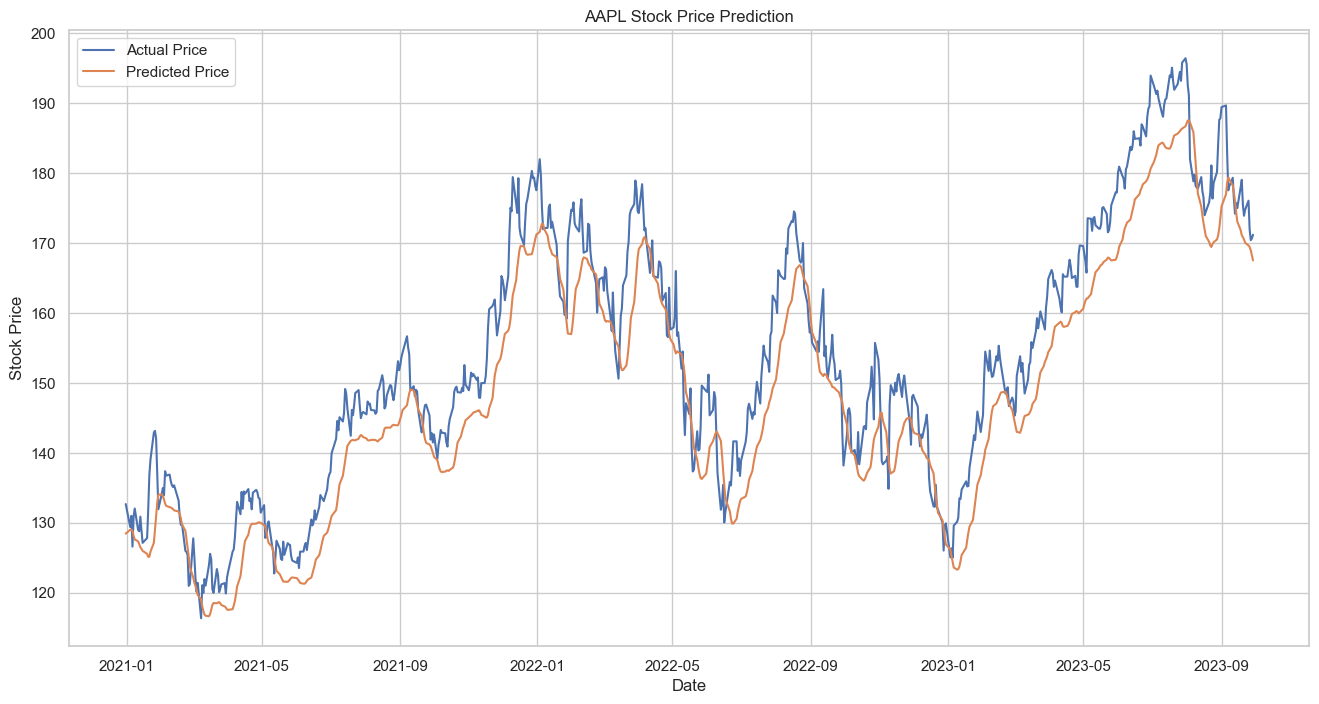

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

np.random.seed(42)

# Fetch historical data
ticker = 'AAPL'
data = yf.download(ticker, start='2010-01-01', end='2023-10-01')

data.reset_index(inplace=True)
data_close = data[['Date', 'Close']]

close_prices = data_close['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_prices)

training_data_len = int(np.ceil(len(scaled_close) * 0.8))
train_data = scaled_close[0:training_data_len, :]
test_data = scaled_close[training_data_len - 60:, :]

def create_sequences(dataset, time_step=60):
    X = []
    y = []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i - time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

epochs = 10
batch_size = 32

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(np.mean(((predictions - y_test_actual) ** 2)))
print(f'Root Mean Square Error: {rmse}')

test_dates = data_close['Date'][training_data_len:]

plt.figure(figsize=(16,8))
plt.plot(test_dates, y_test_actual, label='Actual Price')
plt.plot(test_dates, predictions, label='Predicted Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
